In [1]:
%matplotlib inline
import os
import glob
import datetime as dt
import numpy as np
import platform
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, load_data, multilook, smallbaselineApp, view
plt.rcParams.update({'font.size': 12})

# platform
if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2024NotoEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2024NotoEQ')

# dataset
ds_name = [
    'ALOS2_A121_20220926_20240101_IFG',   # 0
    'ALOS2_D026_20230606_20240102_IFG',   # 1
    'ALOS2_A127_20231206_20240103_IFG',   # 2
    'ALOS2_A128_20230612_20240108_IFG',   # 3
    'ALOS2_D019_20211019_20240109_IFG',   # 4
][0]
redo = True

work_dir = os.path.join(proj_dir, ds_name[:-4], 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input files
lks = '32rlks_40alks'
date1, date2 = ptime.yymmdd(ds_name.split('_')[2:4])
int_file = f'filt_{date1}-{date2}_{lks}.int'
unw_file = f'filt_{date1}-{date2}_{lks}.unw'
cor_file = f'{date1}-{date2}_{lks}.phsig'

# output grid
S, N, W, E = 36.7, 37.6, 136.6, 137.45 # 36.57, 37.61, 136.57, 137.50  #

# output files
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')

Go to directory: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar


In [2]:
config = {
    'ALOS2_A121_20220926_20240101_IFG': {'ymin':800, 'ymax':2200},
    'ALOS2_D026_20230606_20240102_IFG': {'ymin':500,  'ymax':2000},
    'ALOS2_A127_20231206_20240103_IFG': {'ymin':500,  'ymax':2000},
    'ALOS2_A128_20230612_20240108_IFG': {'ymin':0,    'ymax':1400},
    'ALOS2_D019_20211019_20240109_IFG': {'ymin':700,  'ymax':2200},
}[ds_name]
ymin, ymax = config['ymin'], config['ymax']

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .int file: /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/filt_220926-240101_32rlks_40alks.int in complex64 format
file size in y/x: (2483, 668)
input dataset: "['phase']"
num of datasets in file filt_220926-240101_32rlks_40alks.int: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 668, 2483)
subset coverage in y/x: (0, 0, 668, 2483)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: cmy
figure title: filt_220926-240101_32rlks_40alks.int
figure size : [2.7, 8.0]
reading data ...
data    range: [-3.1415832, 3.1415913] radian
display range: [-3.141592653589793, 3.141592653589793] radian
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting data via matplotlib.pyplot.imshow ...
save figure to /panda/yunjunz/2024NotoEQ/ALOS2_A121_2022092

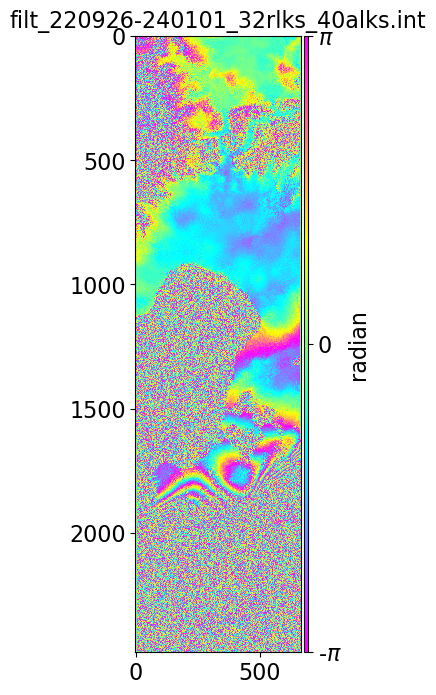

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .phsig file: /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/220926-240101_32rlks_40alks.phsig in float32 format
file size in y/x: (2483, 668)
num of datasets in file 220926-240101_32rlks_40alks.phsig: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 668, 2483)
subset coverage in y/x: (0, 0, 668, 2483)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: gray
figure title: 220926-240101_32rlks_40alks.phsig
figure size : [2.7, 8.0]
reading data ...
data    range: [0.0, 0.9999707] 1
display range: [0.0, 0.9999707] 1
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting data via matplotlib.pyplot.imshow ...
save figure to /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/220926-240101_32rlks_40alks.phsig.png with dpi=300
showing

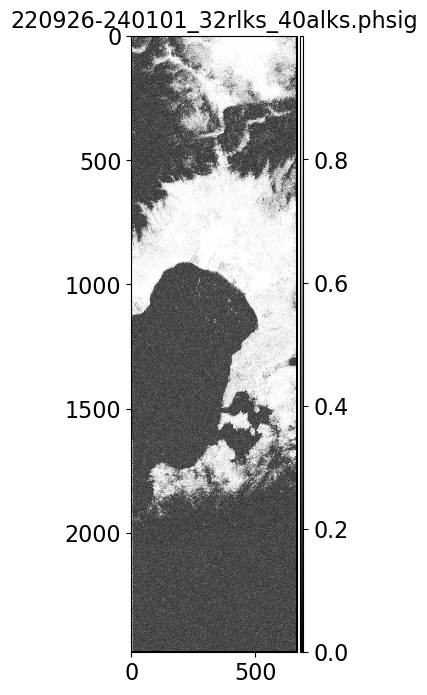

In [3]:
view.main(f'{int_file} phase -c cmy --save --dpi 300'.split())
view.main(f'{cor_file} -c gray --save --dpi 300'.split())

### Geometry

In [4]:
# convert water body into water mask [for mintpy]
cmd = f'generate_mask.py ./{date1}-{date2}_{lks}.wbd --max 0.5 -o ./waterMask.rdr'
!{cmd}

input .wbd file: ./220926-240101_32rlks_40alks.wbd
read ./220926-240101_32rlks_40alks.wbd
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.5
write file: ./waterMask.rdr
write file: ./waterMask.rdr.rsc
time used: 00 mins 0.1 secs.


In [5]:
# write geometry HDF5 file
config_str = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = ../{date2}.track.xml
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = ./{date1}-{date2}_{lks}.hgt
mintpy.load.lookupYFile      = ./{date1}-{date2}_{lks}.lat
mintpy.load.lookupXFile      = ./{date1}-{date2}_{lks}.lon
mintpy.load.incAngleFile     = ./{date1}-{date2}_{lks}.los
mintpy.load.azAngleFile      = ./{date1}-{date2}_{lks}.los
mintpy.load.waterMaskFile    = ./waterMask.rdr
"""
sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config_str)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())

write MintPy configuration to file: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/ALOS2_A121.txt
--------------------------------------------------
Project name: ALOS2_A121
Go to work directory: /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar
copy default template file /home/yunjunz/tools/MintPy/src/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/ALOS2_A121.txt
update default template based on input custom template
    mintpy.load.processor: auto --> isce
    mintpy.load.metaFile: auto --> ../240101.track.xml
    mintpy.load.baselineDir: auto --> None
    mintpy.load.demFile: auto --> ./220926-240101_32rlks_40alks.hgt
    mintpy.load.lookupYFile: auto --> ./220926-240101_32rlks_40alks.lat
    mintpy.load.lookupXFile: auto --> ./220926-240101_32rlks_40alks.lon
    mintpy.load.incAngleFile: auto --> ./220926-240101_32rlks_40alks.los
    mintpy.load.azAngleFil

/home/yunjunz/tools/MintPy/src/mintpy/load_data.py:707: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


create dataset /latitude           of <class 'numpy.float32'>   in size of (2483, 668) with compression = lzf
create dataset /longitude          of <class 'numpy.float32'>   in size of (2483, 668) with compression = lzf
create dataset /incidenceAngle     of <class 'numpy.float32'>   in size of (2483, 668) with compression = lzf
create dataset /azimuthAngle       of <class 'numpy.float32'>   in size of (2483, 668) with compression = lzf
create dataset /waterMask          of <class 'numpy.bool_'>     in size of (2483, 668) with compression = lzf
prepare slantRangeDistance ...
create dataset /slantRangeDistance of <class 'numpy.float32'>   in size of (2483, 668) with compression = lzf
Finished writing to /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5
time used: 00 mins 0.8 secs.



In [6]:
# grab the spatial resolution in meters
meta = readfile.read_attribute(geom_file)
inc_angle_c = float(meta['CENTER_INCIDENCE_ANGLE'])
ystep_m = ut.azimuth_ground_resolution(meta)
xstep_m = ut.range_ground_resolution(meta)
print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m')

# set to the nearest common integer value
step_m = 60 # m, 150 or 60

# convert from meters to degrees
ystep_d = step_m / 108e3
xstep_d = step_m / (108e3 * np.cos(np.deg2rad(inc_angle_c)))
print(f'y/x step [from {step_m} m]: {ystep_d:.8f}, {xstep_d:.8f} deg')

y/x step: 58.5 / 85.3 m
y/x step [from 60 m]: 0.00055556, 0.00065825 deg


### Geocode

geocode.py filt_220926-240101_32rlks_40alks.int -o ./geo/geo_filt_fine.int -l /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0006582534300562624
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0006582534300562624)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.44980517820264)
output file row / column number: (1620, 1291)
[1/1] preparing geometry for dest_box: (0, 0, 1291, 1620) --> reduced src_box: (0, 724, 667, 2409)
--------------------------------------------------
resampling file: filt_220926-240101_32rlks_40alks.int
--------------------------------------------------1/1
reading complex in block (0, 724, 667, 2409) from filt

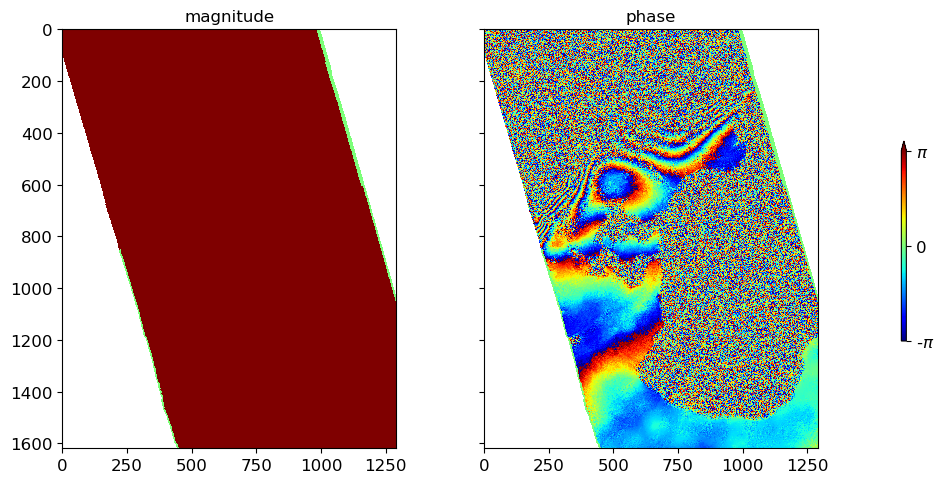

geocode.py filt_220926-240101_32rlks_40alks.unw -o ./geo/geo_filt_fine.unw -l /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0006582534300562624
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0006582534300562624)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.44980517820264)
output file row / column number: (1620, 1291)
[1/1] preparing geometry for dest_box: (0, 0, 1291, 1620) --> reduced src_box: (0, 724, 667, 2409)
--------------------------------------------------
resampling file: filt_220926-240101_32rlks_40alks.unw
--------------------------------------------------1/1
reading magnitude in block (0, 724, 667, 2409) from fi

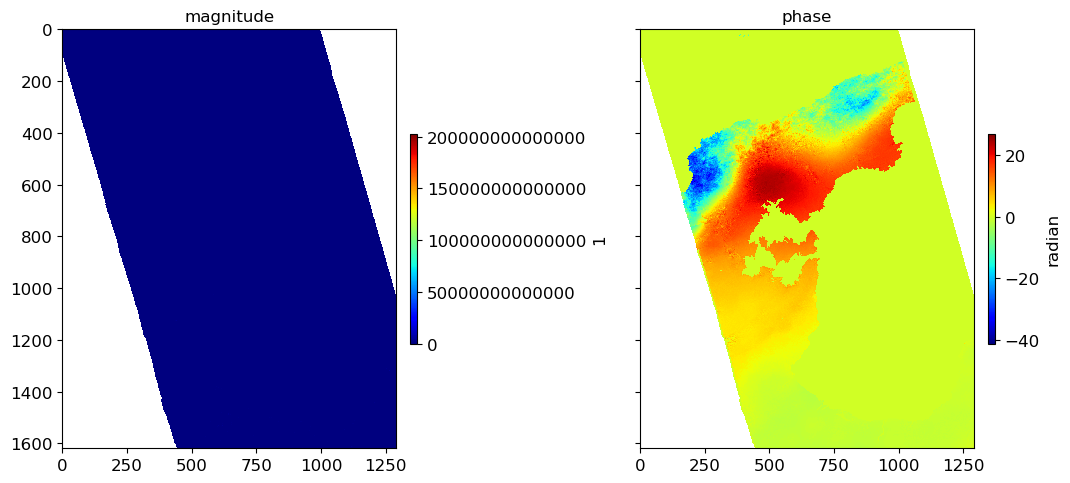

geocode.py 220926-240101_32rlks_40alks.phsig -o ./geo/geo_filt_fine.cor -l /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0006582534300562624
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0006582534300562624)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.44980517820264)
output file row / column number: (1620, 1291)
[1/1] preparing geometry for dest_box: (0, 0, 1291, 1620) --> reduced src_box: (0, 724, 667, 2409)
--------------------------------------------------
resampling file: 220926-240101_32rlks_40alks.phsig
--------------------------------------------------1/1
reading band1 in block (0, 724, 667, 2409) from 220926-24010

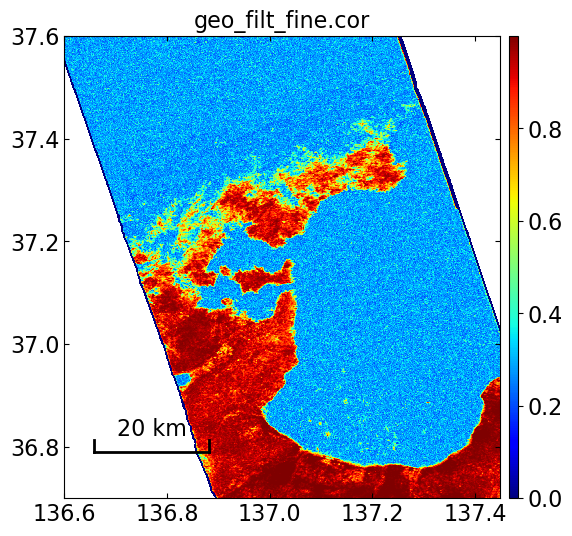

In [7]:
opt = f'-l {geom_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{ystep_d} {xstep_d}'
io_files = [
    [int_file, './geo/geo_filt_fine.int'],
    [unw_file, './geo/geo_filt_fine.unw'],
    [cor_file, './geo/geo_filt_fine.cor'],
]

os.makedirs('./geo', exist_ok=True)
for ifile, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())
        #meta['BANDS'] = 1
        writefile.write_isce_xml(meta, fname=ofile)

    # plot
    view.main(f'{ofile} --noverbose'.split())

### Plot

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .int file: /panda/yunjunz/2024NotoEQ/ALOS2_A121_20220926_20240101/insar/geo/geo_filt_fine.int in complex64 format
file size in y/x: (1620, 1291)
input dataset: "['phase']"
num of datasets in file geo_filt_fine.int: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 1291, 1620)
subset coverage in y/x: (0, 0, 1291, 1620)
data   coverage in lat/lon: (136.6, 37.6, 137.44980517820264, 36.699999999999996)
subset coverage in lat/lon: (136.6, 37.6, 137.44980517820264, 36.699999999999996)
------------------------------------------------------------------------
colormap: jet
initiate cartopy map projection: PlateCarree
figure title: ALOS2_A121_20220926_20240101_IFG
figure size : [7.1, 6.0]
reading data ...
masking pixels with zero value
data    range: [-3.1415832, 3.1415913] radian
display range: [-3.141592653589793, 3.141592653589793] radian
reading DEM: elevation.dem ...
d

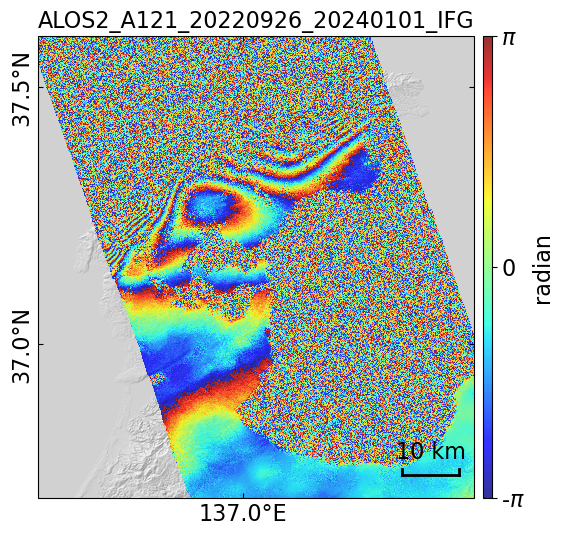

In [8]:
dem_file = os.path.join(proj_dir, 'DEM/elevation.dem')
out_file = os.path.join(proj_dir, f'notebooks/pic/{ds_name}.png')
cmd = f'./geo/geo_filt_fine.int phase --zero-mask --dem {dem_file} --dem-nocontour --shade-exag 0.05 '
cmd += f'--lalo-label --lalo-step 0.5 --scalebar 0.15 0.90 0.05 --title {ds_name} --ylabel-rot 90 '
cmd += f'-o {out_file} '
view.main(cmd.split())